# Project 2 - Supervised Learning

### Let's first check the data in the **train.csv**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
import time

train_data = pd.read_csv('train.csv')

# Remove oversampling
claimed = train_data[train_data['is_claim'] == 1]
not_claimed = train_data[train_data['is_claim'] == 0]
sample_size = min(len(claimed), len(not_claimed))
train_data = pd.concat([claimed.sample(n=sample_size), not_claimed.sample(n=sample_size)])

print(train_data.head())

      policy_id  policy_tenure  age_of_car  age_of_policyholder area_cluster   
11168   ID11169       0.518106        0.08             0.384615          C17  \
33323   ID33324       1.194801        0.14             0.576923           C8   
42409   ID42410       1.216010        0.03             0.500000          C14   
48246   ID48247       1.234073        0.07             0.605769           C8   
42721   ID42722       1.169788        0.15             0.538462           C8   

       population_density  make segment model fuel_type  ... is_brake_assist   
11168               65567     3      C2    M4    Diesel  ...             Yes  \
33323                8794     4      B2    M5    Diesel  ...              No   
42409                7788     5      C1    M9    Diesel  ...              No   
48246                8794     2       A    M3    Petrol  ...              No   
42721                8794     3      C2    M4    Diesel  ...             Yes   

      is_power_door_locks is_central_l

We had to have the same number of claims and not claims to avoid **oversampling**

### Let's check if there are columns with missing values
### And change the non-numeric columns to numeric

In [10]:
cols_with_na = train_data.columns[train_data.isna().any()].tolist()
print('Columns with missing values:', cols_with_na)

# train_data['policy_id'] = train_data['policy_id'].apply(lambda x: x.replace('ID', ''))
train_data.drop('policy_id', axis=1, inplace=True)
train_data['area_cluster'] = train_data['area_cluster'].apply(lambda x: x.replace('C', ''))
train_data = pd.get_dummies(train_data,
                            columns=['segment', 'fuel_type', 'engine_type', 'rear_brakes_type', 'steering_type'])
train_data['model'] = train_data['model'].apply(lambda x: x.replace('M', ''))
train_data = train_data.replace({"Yes": True, "No": False})
encoder = LabelEncoder()
train_data['transmission_type'] = encoder.fit_transform(train_data['transmission_type'])

train_data['max_torque'] = train_data['max_torque'].apply(
    lambda s: float(s.split('Nm@')[0]) * float(s.split('Nm@')[1].replace('rpm', '')))
train_data['max_power'] = train_data['max_power'].apply(
    lambda s: float(s.split('bhp@')[0]) * float(s.split('bhp@')[1].replace('rpm', '')))


Columns with missing values: []


As we can see, there are no missing values in our data set

### Let's now get some more general information of our features

In [21]:
print(train_data.describe())

       policy_tenure   age_of_car  age_of_policyholder  population_density   
count    7496.000000  7496.000000          7496.000000         7496.000000  \
mean        0.665598     0.066826             0.473151        18124.893276   
std         0.407349     0.054818             0.124837        16925.507386   
min         0.002801     0.000000             0.288462          290.000000   
25%         0.272972     0.020000             0.375000         6112.000000   
50%         0.679824     0.060000             0.461538         8794.000000   
75%         1.062395     0.110000             0.548077        27003.000000   
max         1.386520     0.420000             0.951923        73430.000000   

              make     max_torque      max_power      airbags  displacement   
count  7496.000000    7496.000000    7496.000000  7496.000000   7496.000000  \
mean      1.761873  444872.549360  403494.844450     3.135806   1167.026014   
std       1.139148  181037.909914  115799.867806     1.83639

In [ ]:
% matplotlib inline

sb.pairplot(train_data)

After some investigating, there are no major outliers that require work.
There are some variables that seem to have no correlation with the `is_claim` feature

### Now let's check what features have no correlation with the test feature

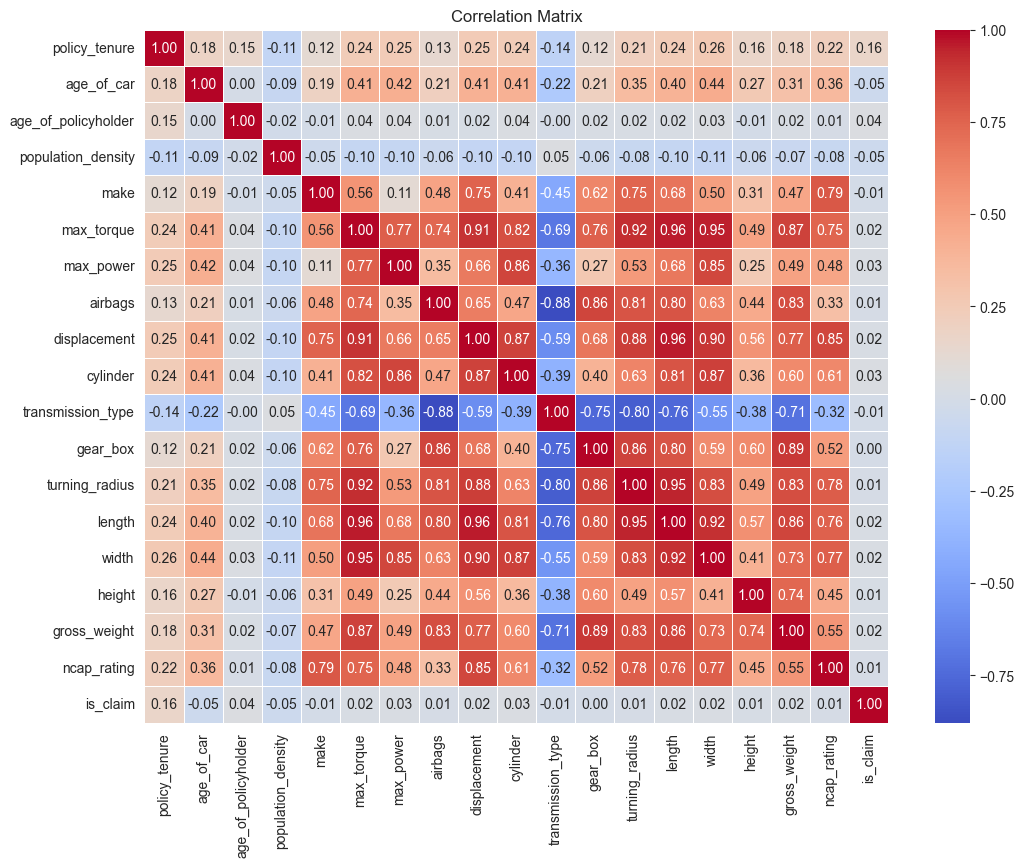

In [11]:

numeric_columns = train_data.select_dtypes(include='number')
train_data_numeric = train_data[numeric_columns.columns]

correlation_matrix = train_data_numeric.corr()

# Creating the subsets without the highly correlated features
corr_cols08 = set()
corr_cols09 = set()
corr_cols07 = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if correlation_matrix.columns[i] != correlation_matrix.columns[j] and abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[j]
            corr_cols08.add(colname)

        if correlation_matrix.columns[i] != correlation_matrix.columns[j] and abs(correlation_matrix.iloc[i, j]) > 0.9:
            colname = correlation_matrix.columns[j]
            corr_cols09.add(colname)

        if correlation_matrix.columns[i] != correlation_matrix.columns[j] and abs(correlation_matrix.iloc[i, j]) > 0.7:
            colname = correlation_matrix.columns[j]
            corr_cols07.add(colname)

train_data_08 = train_data_numeric.drop(columns=corr_cols08)
train_data_09 = train_data_numeric.drop(columns=corr_cols09)
train_data_07 = train_data_numeric.drop(columns=corr_cols07)

train_data.to_csv('fixed_train_data.csv', index=False)
train_data_08.to_csv('fixed_train_data_08.csv', index=False)
train_data_09.to_csv('fixed_train_data_09.csv', index=False)
train_data_07.to_csv('fixed_train_data_07.csv', index=False)

plt.figure(figsize=(12, 9))
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

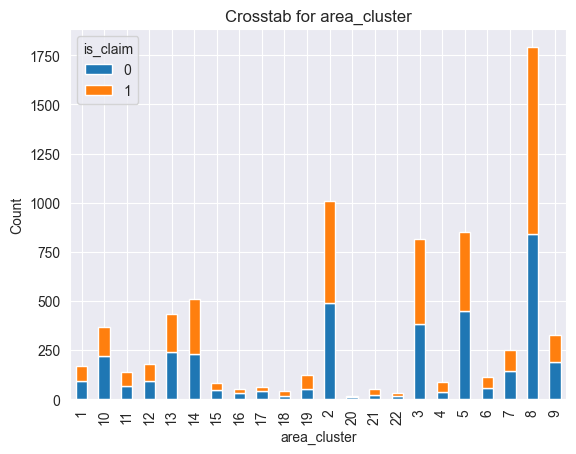

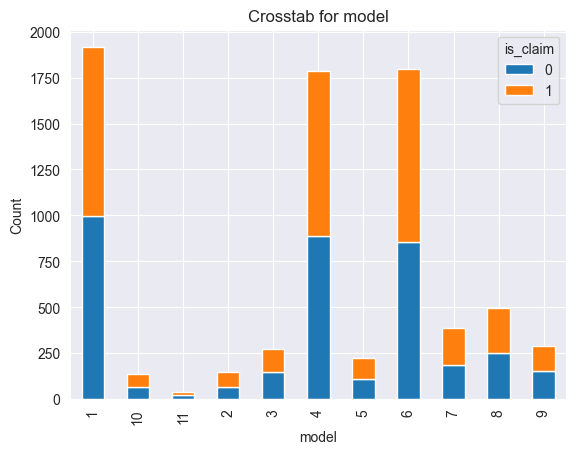

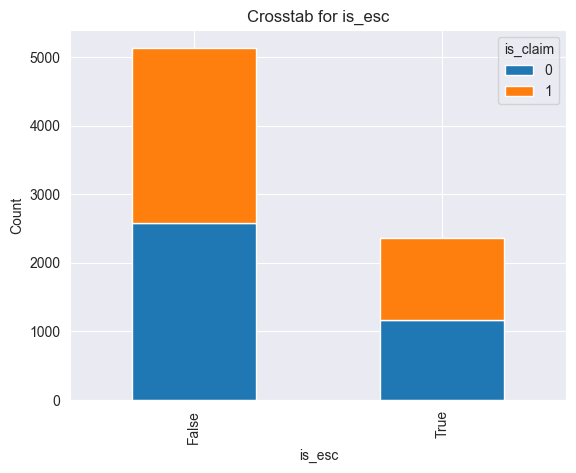

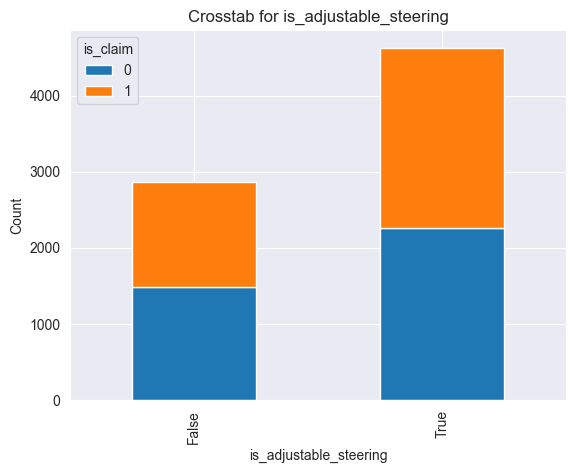

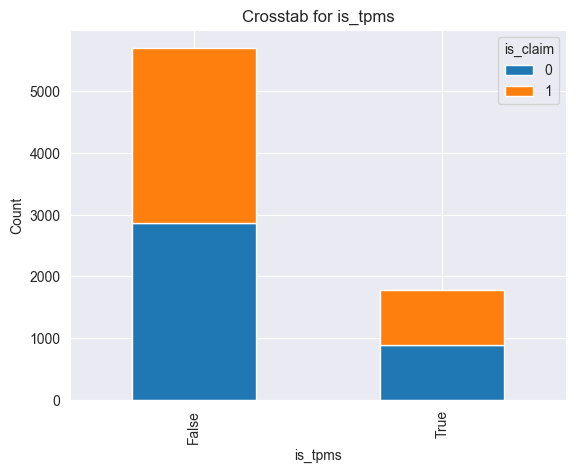

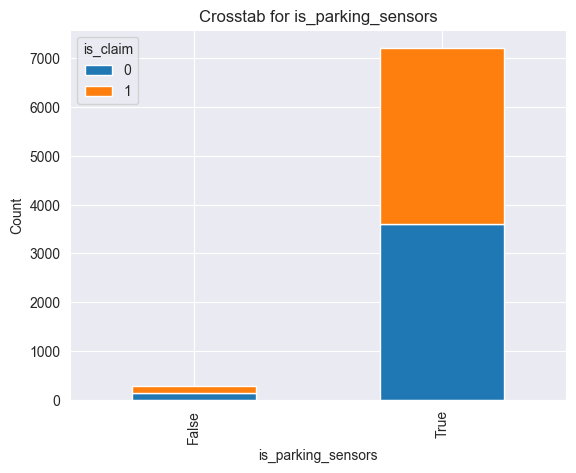

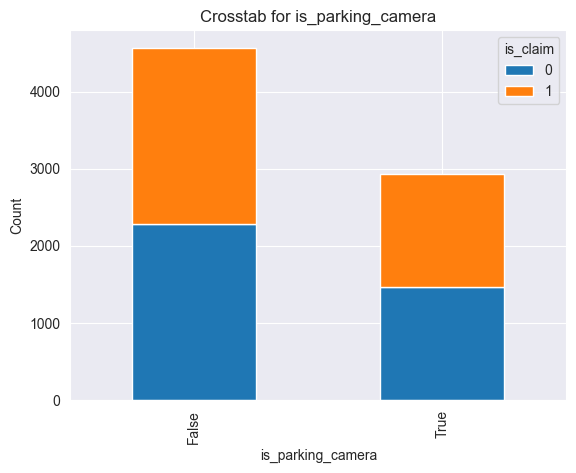

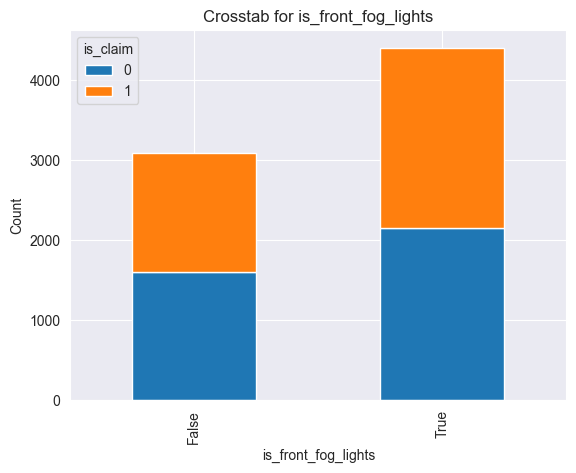

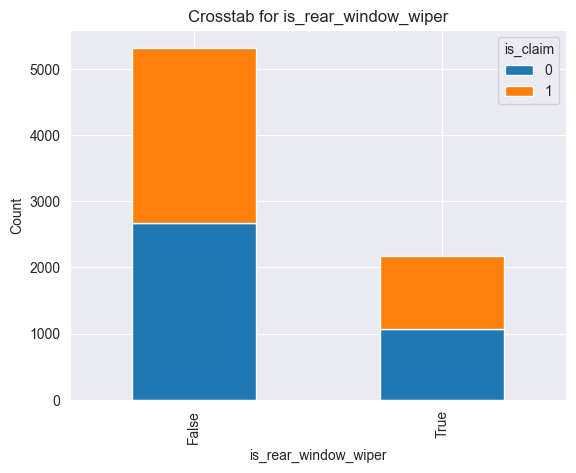

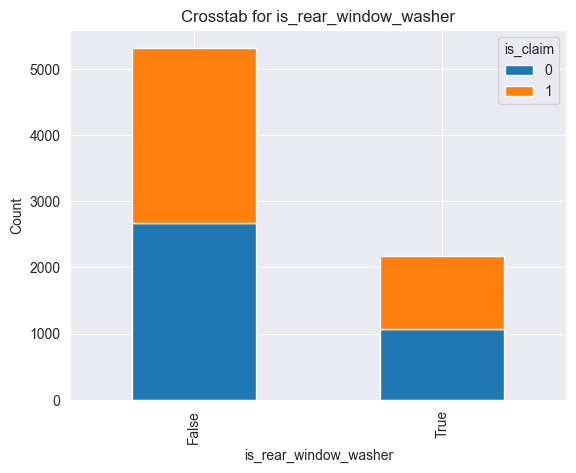

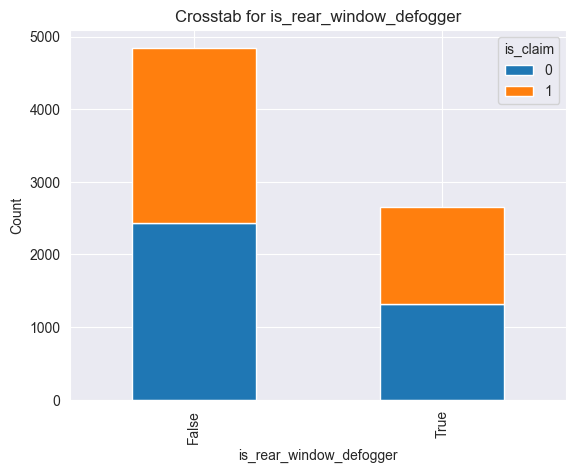

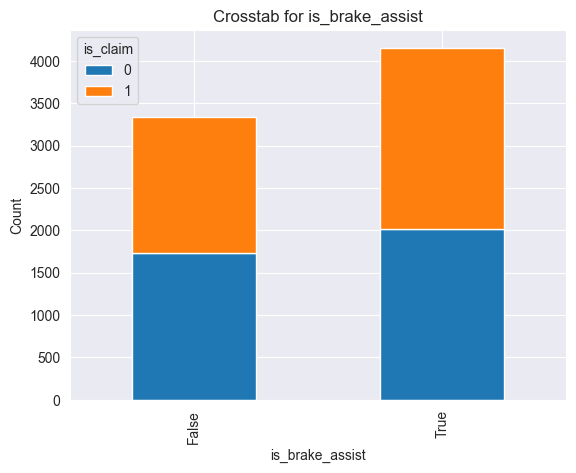

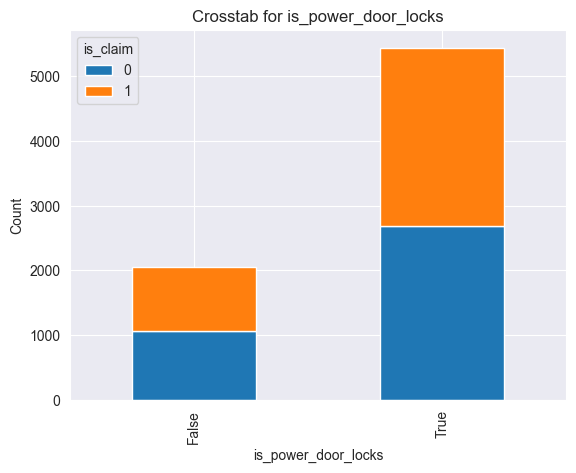

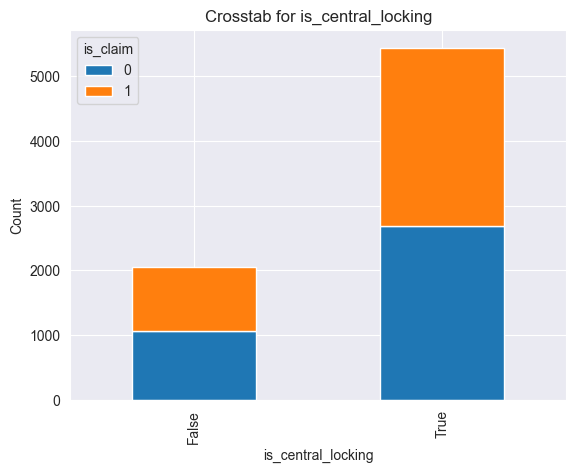

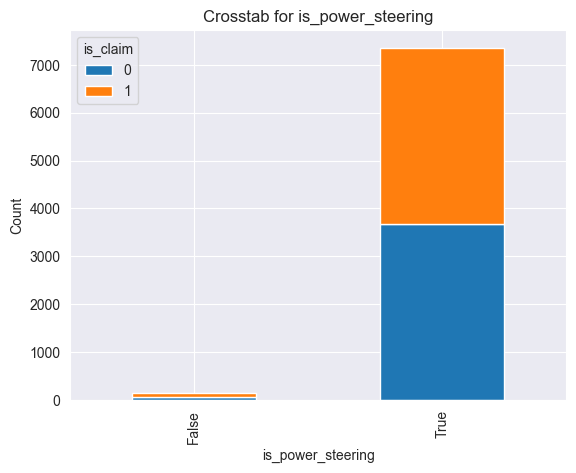

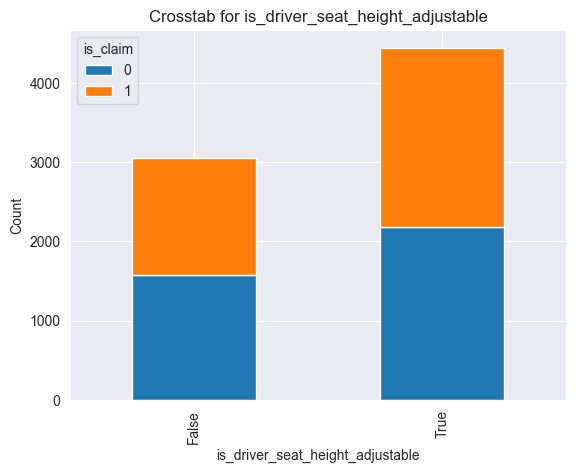

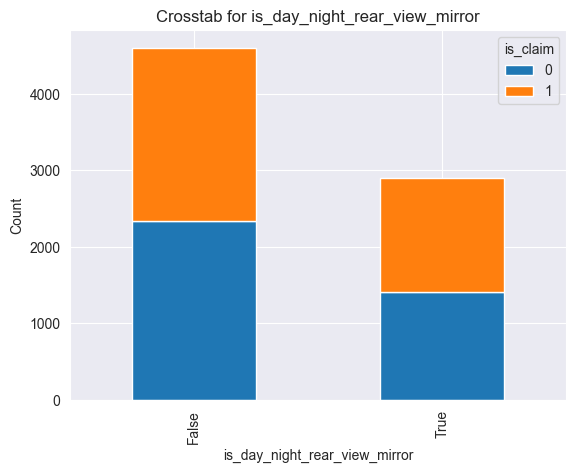

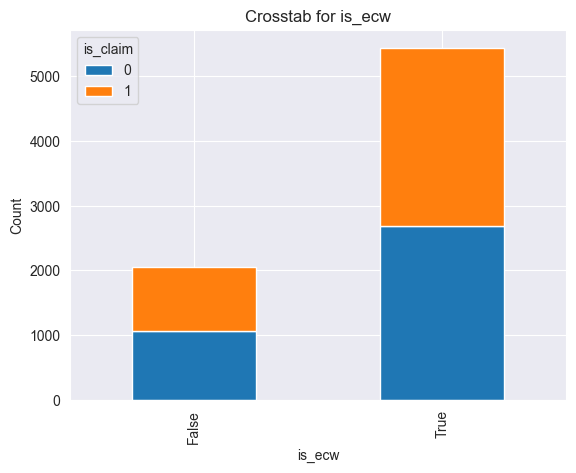

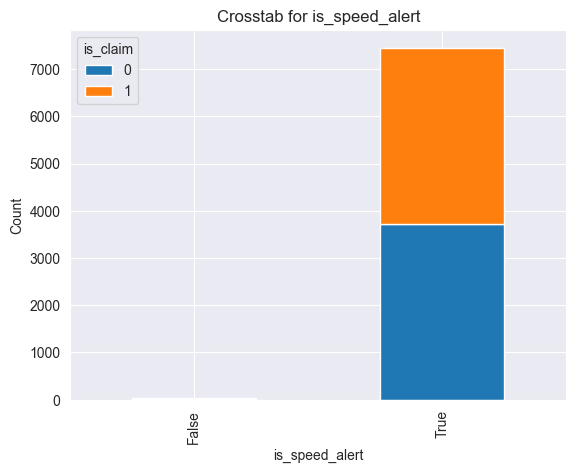

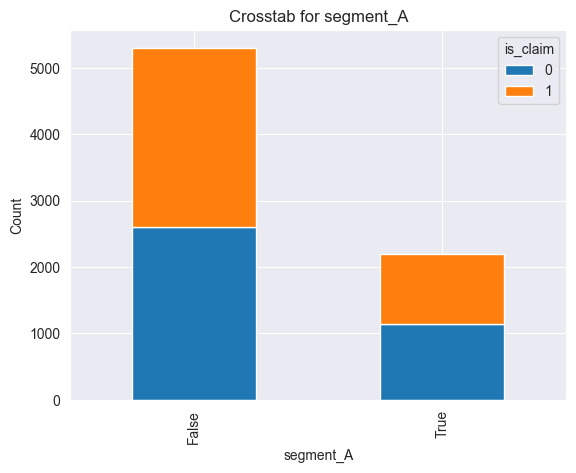

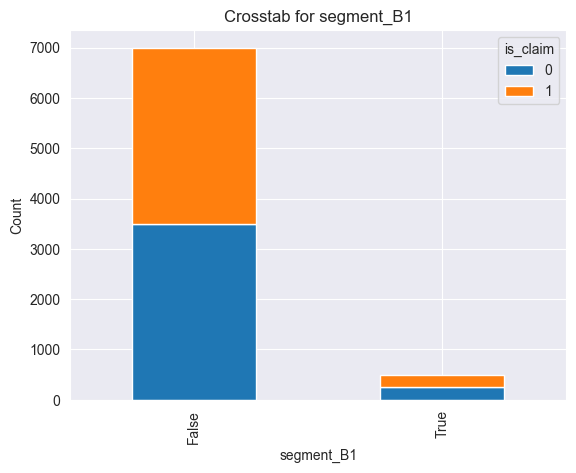

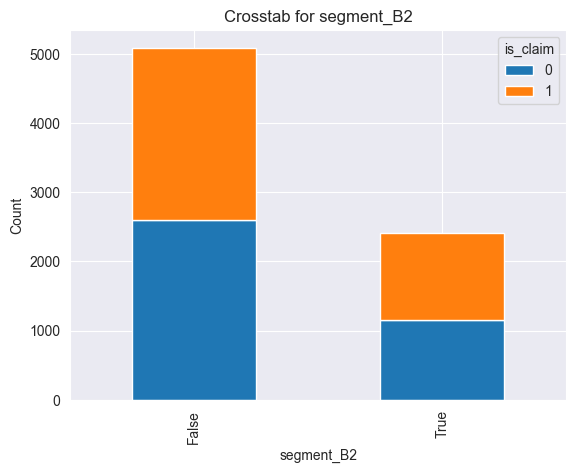

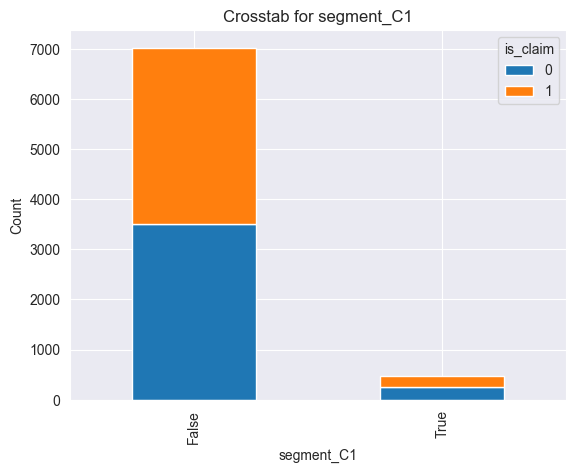

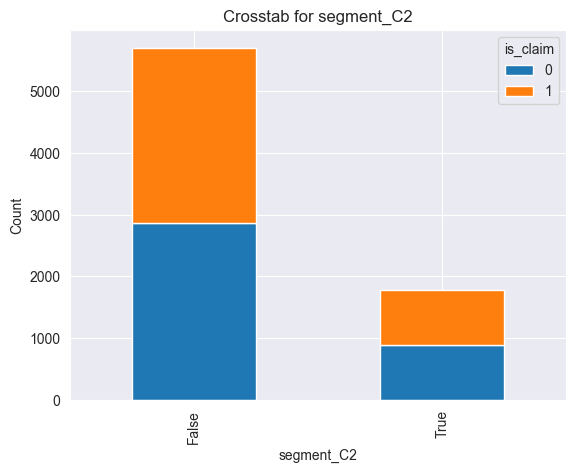

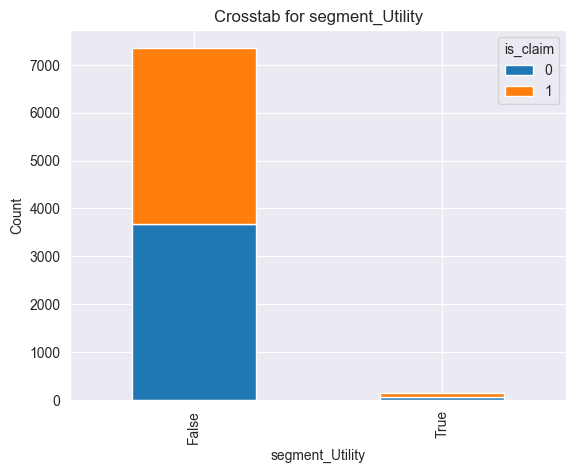

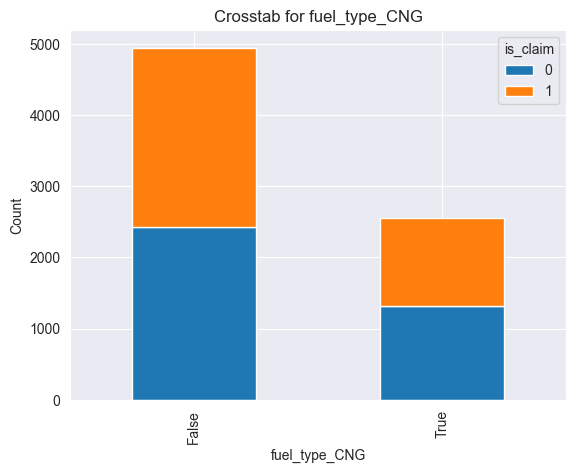

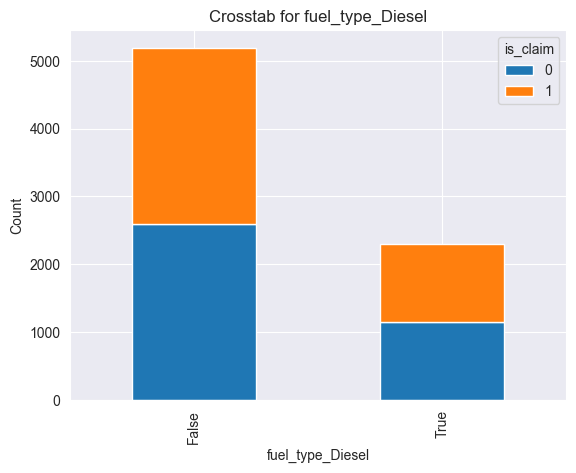

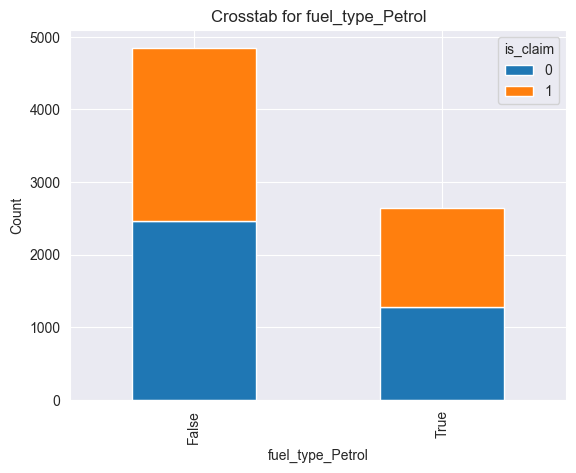

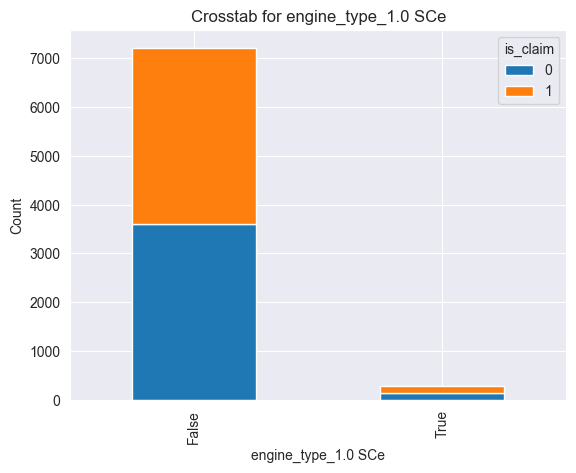

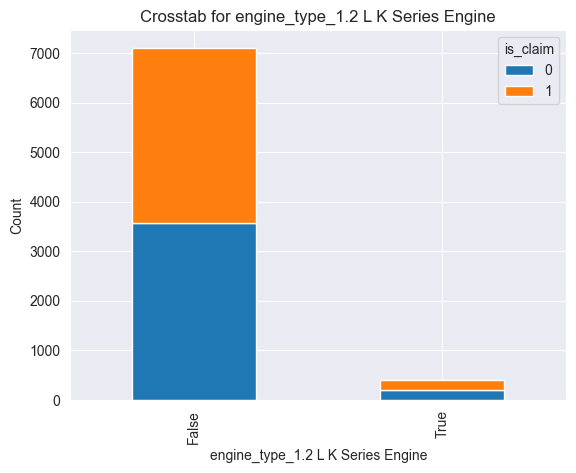

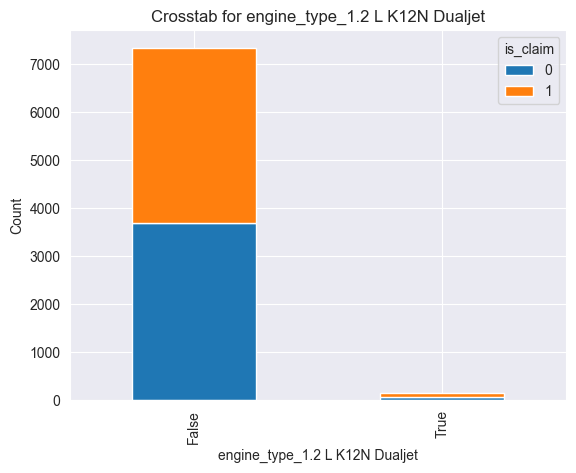

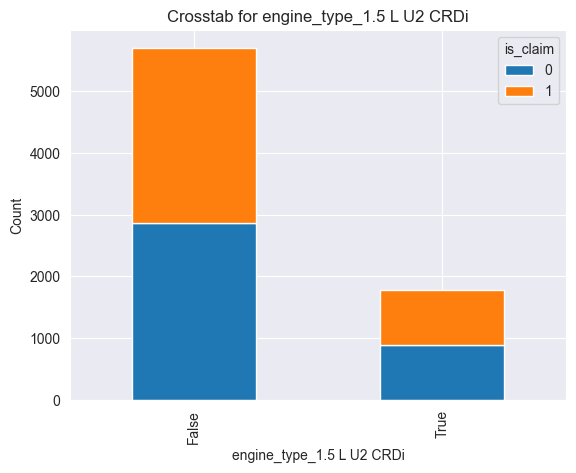

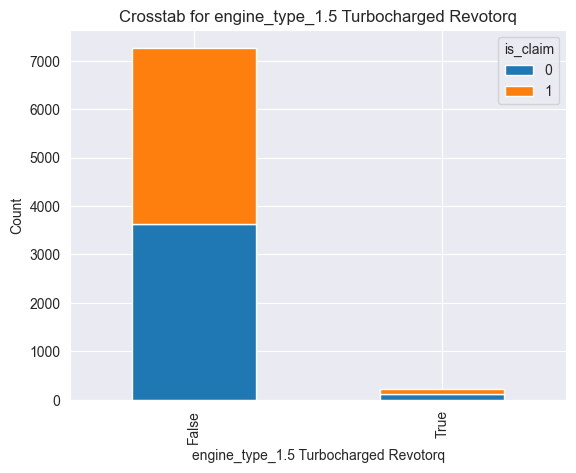

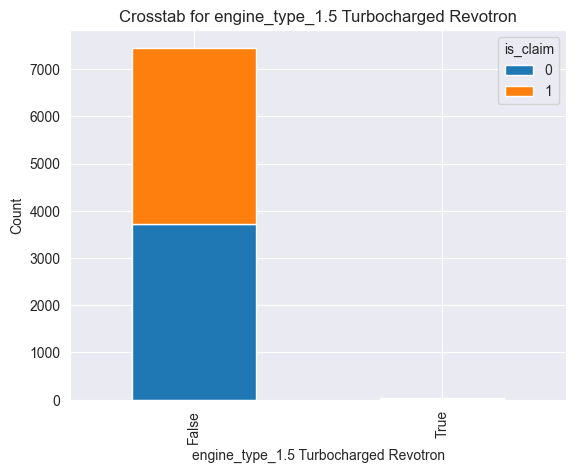

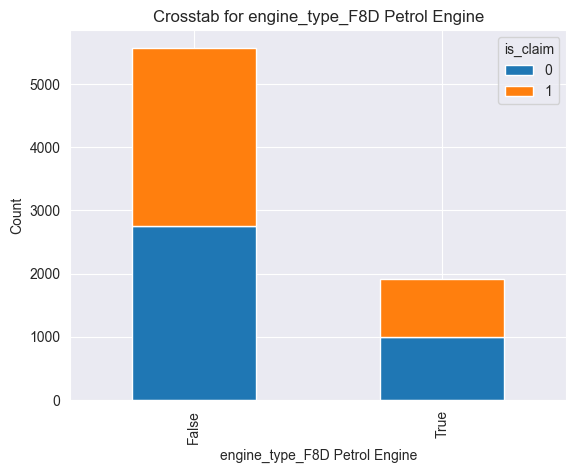

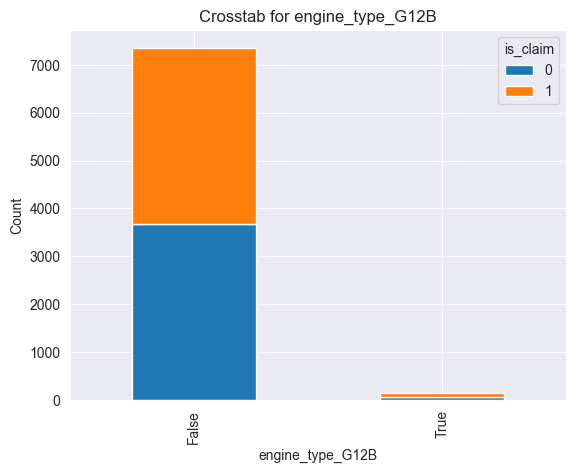

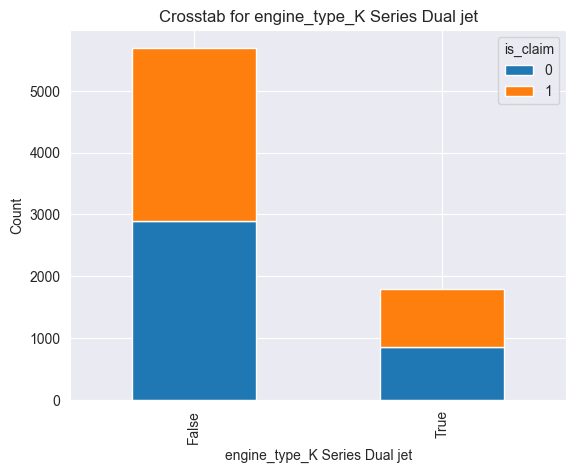

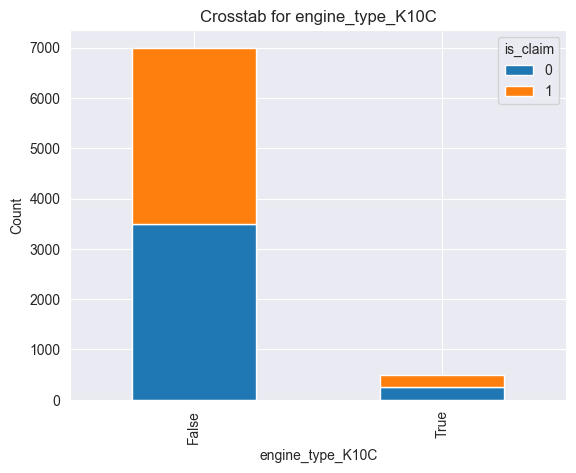

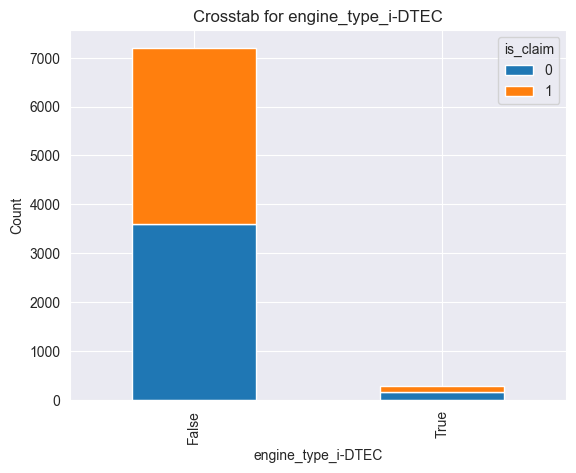

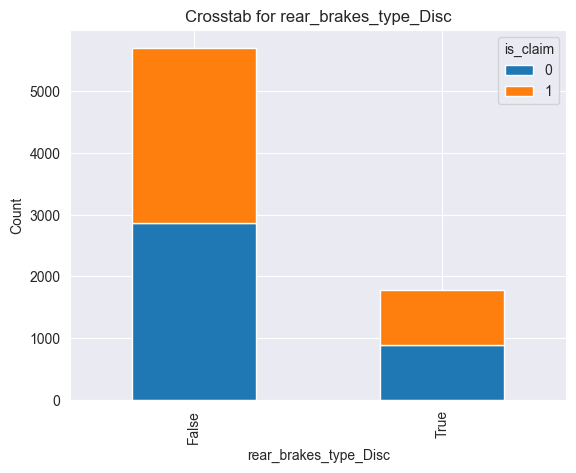

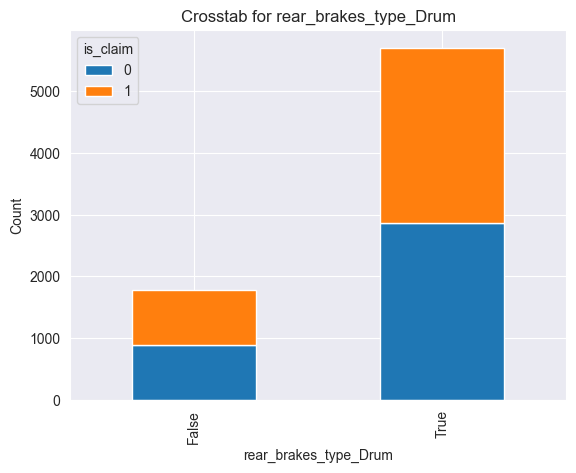

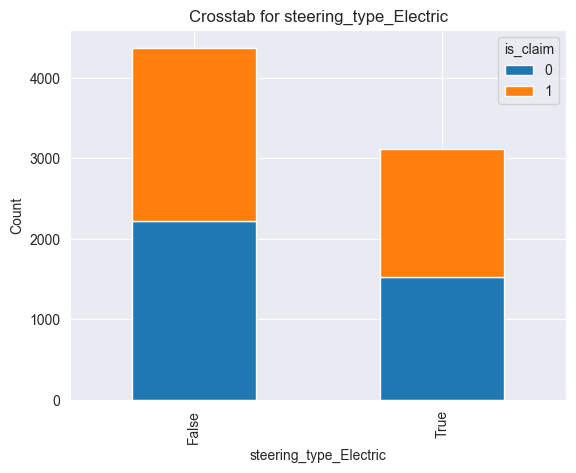

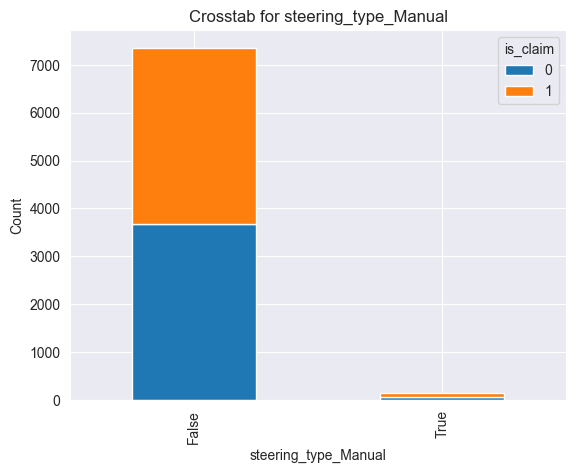

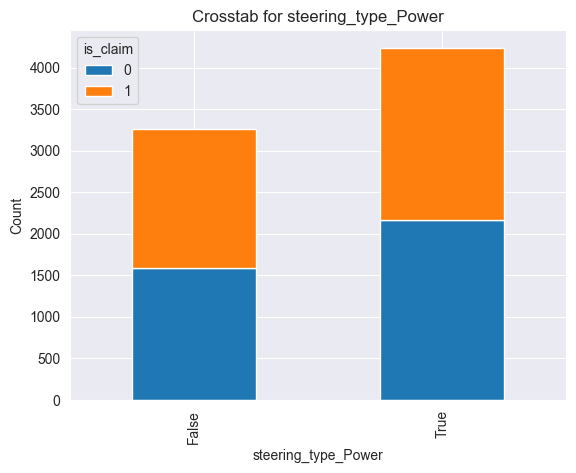

In [12]:
non_numeric_columns = train_data.select_dtypes(exclude='number')

for column in non_numeric_columns:
    if 'id' in column: continue
    crosstab_table = pd.crosstab(train_data[column], train_data['is_claim'])
    crosstab_table.plot(kind='bar', stacked=True)

    plt.title(f'Crosstab for {column}')
    plt.xlabel(column)
    plt.ylabel('Count')

    plt.show()



Numeric features don't correlate with the `is_claim` feature, most probably because it is a binary feature and not a number one.
But there are others features that correlate with each other, which might give more strength to those values, something that we want to avoid.
A good way of avoiding it is to remove the column that correlate too much with another (>= 0.85)

In non-numeric features we didn't get a clear separation but there are some choices that are more favorable. For example in the feature `segment`, people insure more an `A` than a `Utility` value

### Let's now dive into the classifier methods

We have done an initial comparison of all the algorithms

In [13]:
classifiers = {
    'Decision Tree': DecisionTreeClassifier(),
    'Neural Network': MLPClassifier(),
    'K-NN': KNeighborsClassifier(),
    'SVM': SVC()
}
target_column = "is_claim"
X = train_data.drop(target_column, axis=1)
y = train_data[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Numeric features don't correlate with the `is_claim` feature, most probably because it is a binary feature and not a number one.
But there are others features that correlate with each other, which might give more strength to those values, something that we want to avoid.
A good way of avoiding it is to remove the column that correlate too much with another (>= 0.85)

In non-numeric features we didn't get a clear separation but there are some choices that are more favorable. For example in the feature `segment`, people insure more an `A` than a `Utility` value

### Let's now dive into the classifier methods

We have done an initial comparison of all the algorithms

In [11]:
classifiers = {
    'Decision Tree': DecisionTreeClassifier(),
    'Neural Network': MLPClassifier(),
    'K-NN': KNeighborsClassifier(),
    'SVM': SVC()
}
target_column = "is_claim"
X = train_data.drop(target_column, axis=1)
y = train_data[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
        Classifier          Confusion Matrix  Precision    Recall  Accuracy   
0    Decision Tree  [[596, 522], [565, 566]]   0.516805  0.516674  0.516674  \
1    Decision Tree  [[609, 509], [551, 580]]   0.528821  0.528679  0.528679   
2    Decision Tree  [[609, 509], [555, 576]]   0.527058  0.526901  0.526901   
3    Decision Tree  [[601, 517], [562, 569]]   0.520375  0.520231  0.520231   
4    Decision Tree  [[612, 506], [552, 579]]   0.529730  0.529569  0.529569   
5   Neural Network  [[567, 551], [546, 585]]   0.512215  0.512228  0.512228   
6   Neural Network    [[1118, 0], [1131, 0]]   0.750008  0.497110  0.497110   
7   Neural Network  [[27, 1091], [27, 1104]]   0.501489  0.502890  0.502890   
8   Neural Network  [[27, 1091], [24, 1107]]   0.516451  0.504224  0.504224   
9   Neural Network  [[22, 1096], [18, 1113]]   0.526791  0.504669  0.504669   
10            K-NN  [[636, 482], [517, 614]]   0.555937  0.555803  0.555803   
11          

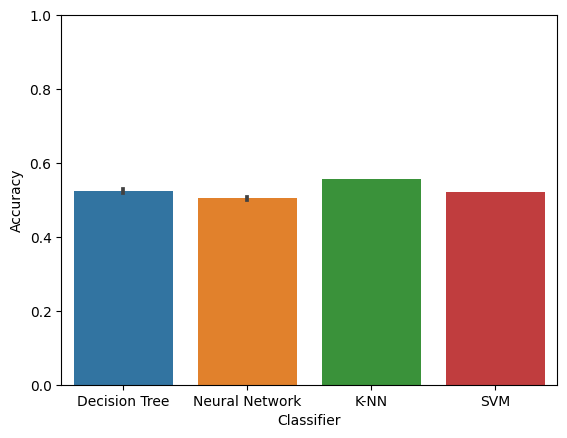

In [12]:
# Train and evaluate the classifiers
results = []

for (name, classifier) in classifiers.items():

    for _ in range(5):
        # Train the model
        start_time = time.time()
        classifier.fit(X_train, y_train)
        train_time = time.time() - start_time

        # Test the model
        start_time = time.time()
        y_pred = classifier.predict(X_test)
        test_time = time.time() - start_time

        # Calculate evaluation metrics
        conf_matrix = confusion_matrix(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
        recall = recall_score(y_test, y_pred, average='weighted')
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Store the results
        results.append({
            'Classifier': name,
            'Confusion Matrix': conf_matrix,
            'Precision': precision,
            'Recall': recall,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'Train Time': train_time,
            'Test Time': test_time
        })
# Convert the results into a DataFrame
results_df = pd.DataFrame(results)

# Display the results
print(results_df)

plt.ylim(0, 1)
sb.barplot(x='Classifier', y='Accuracy', data=results_df)
plt.show()

### Neural Network

We tested 4 sets:

- Default Set
- Set without more than 90% correlated information
- Set without more than 80% correlated information
- Set without more than 70% correlated information

With 3 division methods:

- Random division (70/30)
- Random division (80/20)
- Stratified folds (5 folds)

0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
                   Set           Confusion Matrix  Precision    Recall   
0          Default Set    [[1102, 9], [1128, 10]]   0.510436  0.494442  \
1          Default Set   [[916, 209], [905, 219]]   0.507349  0.504669   
2          Default Set   [[502, 632], [469, 646]]   0.511284  0.510449   
3          Default Set     [[1132, 0], [1117, 0]]   0.750011  0.503335   
4          Default Set   [[568, 540], [625, 516]]   0.482465  0.481992   
5   >= 0.9 correlation     [[0, 1119], [1, 1129]]   0.252340  0.502001   
6   >= 0.9 correlation     [[0, 1128], [0, 1121]]   0.750002  0.498444   
7   >= 0.9 correlation     [[1118, 0], [1131, 0]]   0.750008  0.497110   
8   >= 0.9 correlation     [[0, 1140], [0, 1109]]   0.750047  0.493108   
9   >= 0.9 correlation     [[1154, 0], [1095, 0]]   0.750172  0.513117   
10  >= 0.8 correlation  [[1028, 139], [954, 128]]   0.499776  0.514006   
11  >= 0.8 correlation   [[10, 1096], [15, 1128]]   0.454479  0.506003  

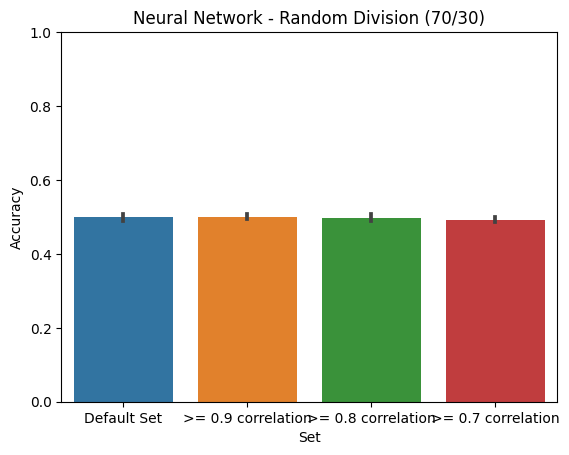

In [13]:
sets = {
    'Default Set': train_data,
    '>= 0.9 correlation': train_data_09,
    '>= 0.8 correlation': train_data_08,
    '>= 0.7 correlation': train_data_07,
}

results = []

for (name, data_set) in sets.items():
    # Train the model
    for _ in range(5):  #running 5 times each
        neural_network = MLPClassifier()
        target_column = "is_claim"
        X = data_set.drop(target_column, axis=1)
        y = data_set[target_column]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        start_time = time.time()

        neural_network.fit(X_train, y_train)
        train_time = time.time() - start_time

        # Test the model
        start_time = time.time()
        y_pred = neural_network.predict(X_test)
        test_time = time.time() - start_time

        # Calculate evaluation metrics
        conf_matrix = confusion_matrix(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
        recall = recall_score(y_test, y_pred, average='weighted')
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Store the results
        results.append({
            'Set': name,
            'Confusion Matrix': conf_matrix,
            'Precision': precision,
            'Recall': recall,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'Train Time': train_time,
            'Test Time': test_time
        })
# Convert the results into a DataFrame
results_df = pd.DataFrame(results)

# Display the results
print(results_df)

plt.ylim(0, 1)
plt.title("Neural Network - Random Division (70/30)")
sb.barplot(x='Set', y='Accuracy', data=results_df)
plt.show()

0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
0
1
2
3
4
                   Set          Confusion Matrix  Precision    Recall   
0          Default Set    [[20, 767], [27, 686]]   0.447680  0.470667  \
1          Default Set      [[742, 0], [758, 0]]   0.750028  0.494667   
2          Default Set      [[0, 739], [1, 760]]   0.257220  0.506667   
3          Default Set  [[175, 579], [207, 539]]   0.470049  0.476000   
4          Default Set      [[738, 0], [762, 0]]   0.750064  0.492000   
5   >= 0.9 correlation      [[0, 785], [0, 715]]   0.750544  0.476667   
6   >= 0.9 correlation      [[772, 0], [728, 0]]   0.750215  0.514667   
7   >= 0.9 correlation      [[718, 0], [782, 0]]   0.750455  0.478667   
8   >= 0.9 correlation      [[0, 754], [0, 746]]   0.750007  0.497333   
9   >= 0.9 correlation     [[10, 761], [3, 726]]   0.632665  0.490667   
10  >= 0.8 correlation  [[407, 329], [406, 358]]   0.511052  0.510000   
11  >= 0.8 correlation      [[0, 736], [0, 764]]   0.750087  0.509333   
12  >= 0.8 

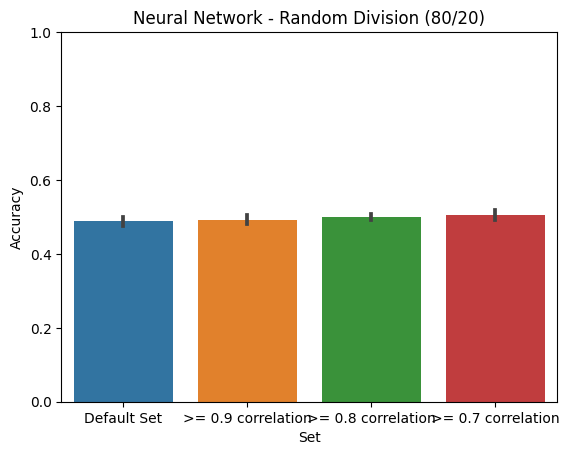

In [14]:
sets = {
    'Default Set': train_data,
    '>= 0.9 correlation': train_data_09,
    '>= 0.8 correlation': train_data_08,
    '>= 0.7 correlation': train_data_07,
}

results = []

for (name, data_set) in sets.items():
    # Train the model
    for _ in range(5):  #running 5 times each
        neural_network = MLPClassifier()
        target_column = "is_claim"
        X = data_set.drop(target_column, axis=1)
        y = data_set[target_column]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        start_time = time.time()

        neural_network.fit(X_train, y_train)
        train_time = time.time() - start_time

        # Test the model
        start_time = time.time()
        y_pred = neural_network.predict(X_test)
        test_time = time.time() - start_time

        # Calculate evaluation metrics
        conf_matrix = confusion_matrix(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
        recall = recall_score(y_test, y_pred, average='weighted')
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Store the results
        results.append({
            'Set': name,
            'Confusion Matrix': conf_matrix,
            'Precision': precision,
            'Recall': recall,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'Train Time': train_time,
            'Test Time': test_time
        })
# Convert the results into a DataFrame
results_df = pd.DataFrame(results)

# Display the results
print(results_df)

plt.ylim(0, 1)
plt.title("Neural Network - Random Division (80/20)")
sb.barplot(x='Set', y='Accuracy', data=results_df)
plt.show()

                   Set          Confusion Matrix  Precision    Recall   
0          Default Set  [[616, 134], [619, 131]]   0.496563  0.498000  \
1          Default Set    [[719, 30], [709, 41]]   0.540508  0.507005   
2          Default Set      [[749, 0], [750, 0]]   0.750000  0.499666   
3          Default Set    [[19, 731], [20, 729]]   0.493243  0.498999   
4          Default Set      [[0, 750], [0, 749]]   0.750000  0.499666   
5   >= 0.9 correlation      [[0, 750], [0, 750]]   0.750000  0.500000   
6   >= 0.9 correlation    [[729, 20], [740, 10]]   0.414740  0.492995   
7   >= 0.9 correlation      [[3, 746], [1, 749]]   0.625419  0.501668   
8   >= 0.9 correlation      [[750, 0], [749, 0]]   0.750000  0.500334   
9   >= 0.9 correlation      [[0, 750], [0, 749]]   0.750000  0.499666   
10  >= 0.8 correlation  [[318, 432], [323, 427]]   0.496595  0.496667   
11  >= 0.8 correlation      [[743, 6], [741, 9]]   0.550370  0.501668   
12  >= 0.8 correlation   [[99, 650], [109, 641]]   

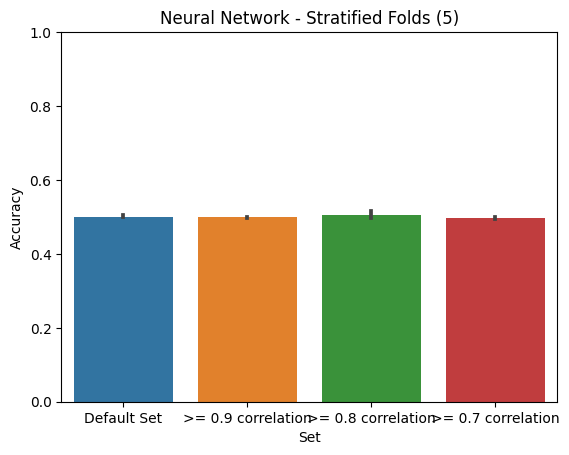

In [15]:
sets = {
    'Default Set': train_data,
    '>= 0.9 correlation': train_data_09,
    '>= 0.8 correlation': train_data_08,
    '>= 0.7 correlation': train_data_07,
}

results = []
skf = StratifiedKFold(n_splits=5)

for (name, data_set) in sets.items():
    neural_network = MLPClassifier()
    target_column = "is_claim"
    X = data_set.drop(target_column, axis=1)
    y = data_set[target_column]
    for train_index, test_index in skf.split(X, y):
        # Train the model
        X_train, X_test = X.values[train_index], X.values[test_index]
        y_train, y_test = y.values[train_index], y.values[test_index]
        start_time = time.time()

        neural_network.fit(X_train, y_train)
        train_time = time.time() - start_time

        # Test the model
        start_time = time.time()
        y_pred = neural_network.predict(X_test)
        test_time = time.time() - start_time

        # Calculate evaluation metrics
        conf_matrix = confusion_matrix(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
        recall = recall_score(y_test, y_pred, average='weighted')
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Store the results
        results.append({
            'Set': name,
            'Confusion Matrix': conf_matrix,
            'Precision': precision,
            'Recall': recall,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'Train Time': train_time,
            'Test Time': test_time
        })
# Convert the results into a DataFrame
results_df = pd.DataFrame(results)

# Display the results
print(results_df)

plt.ylim(0, 1)
plt.title("Neural Network - Stratified Folds (5)")
sb.barplot(x='Set', y='Accuracy', data=results_df)
plt.show()

                   Set          Confusion Matrix  Precision    Recall   
0          Default Set     [[737, 13], [742, 8]]   0.439631  0.496667  \
1          Default Set    [[91, 658], [66, 684]]   0.544629  0.517011   
2          Default Set      [[0, 749], [0, 750]]   0.750000  0.500334   
3          Default Set      [[0, 750], [0, 749]]   0.750000  0.499666   
4          Default Set      [[0, 750], [0, 749]]   0.750000  0.499666   
5   >= 0.9 correlation      [[0, 750], [0, 750]]   0.750000  0.500000   
6   >= 0.9 correlation    [[14, 735], [19, 731]]   0.461464  0.496998   
7   >= 0.9 correlation      [[0, 749], [0, 750]]   0.750000  0.500334   
8   >= 0.9 correlation      [[0, 750], [0, 749]]   0.750000  0.499666   
9   >= 0.9 correlation      [[750, 0], [749, 0]]   0.750000  0.500334   
10  >= 0.8 correlation    [[16, 734], [13, 737]]   0.526372  0.502000   
11  >= 0.8 correlation      [[3, 746], [5, 745]]   0.437374  0.498999   
12  >= 0.8 correlation  [[257, 492], [227, 523]]   

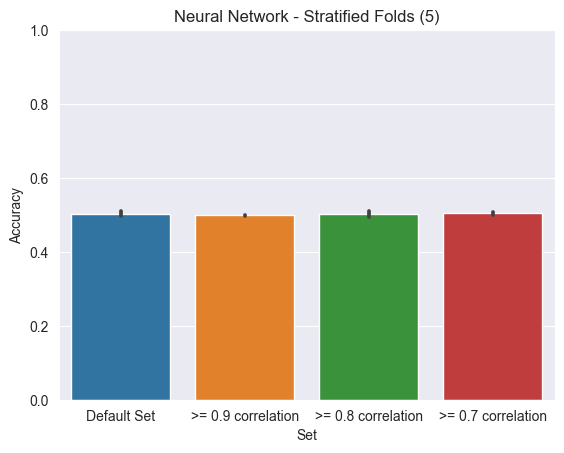

In [25]:
sets = {
    'Default Set': train_data,
    '>= 0.9 correlation': train_data_09,
    '>= 0.8 correlation': train_data_08,
    '>= 0.7 correlation': train_data_07,
}

results = []
skf = StratifiedKFold(n_splits=5)

for (name, data_set) in sets.items():
    neural_network = MLPClassifier()
    target_column = "is_claim"
    X = data_set.drop(target_column, axis=1)
    y = data_set[target_column]
    for train_index, test_index in skf.split(X, y):
        # Train the model
        X_train, X_test = X.values[train_index], X.values[test_index]
        y_train, y_test = y.values[train_index], y.values[test_index]
        start_time = time.time()

        neural_network.fit(X_train, y_train)
        train_time = time.time() - start_time

        # Test the model
        start_time = time.time()
        y_pred = neural_network.predict(X_test)
        test_time = time.time() - start_time

        # Calculate evaluation metrics
        conf_matrix = confusion_matrix(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
        recall = recall_score(y_test, y_pred, average='weighted')
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Store the results
        results.append({
            'Set': name,
            'Confusion Matrix': conf_matrix,
            'Precision': precision,
            'Recall': recall,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'Train Time': train_time,
            'Test Time': test_time
        })
# Convert the results into a DataFrame
results_df = pd.DataFrame(results)

# Display the results
print(results_df)

plt.ylim(0, 1)
plt.title("Neural Network - Stratified Folds (5)")
sb.barplot(x='Set', y='Accuracy', data=results_df)
plt.show()

Regarding the Decision Tree model, we used the GridSearchCV component of the sklearn package in order to find out the parameters combination that produces the best outcome, for each dataset. Furthermore, we also use some plots to make the comparison easier and more intuitive.

In [16]:
params = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [1, 2, 5, 10, 20, 40, 80, 160, 320, 640, None],
    'min_samples_split': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'min_samples_leaf': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    'max_features': [None] + [x for x in range(1, len(train_data.columns))]
}
names = ['Train Data', 'Train Data 07', 'Train Data 08', 'Train Data 09']
datasets = [train_data, train_data_07, train_data_08, train_data_09]
target_column = "is_claim"
results = []

{'criterion': 'entropy', 'max_depth': 10, 'max_features': 43, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1, 'splitter': 'best'}
{'criterion': 'entropy', 'max_depth': 80, 'max_features': 4, 'min_samples_leaf': 0.1, 'min_samples_split': 0.3, 'splitter': 'best'}
{'criterion': 'entropy', 'max_depth': 40, 'max_features': 5, 'min_samples_leaf': 0.1, 'min_samples_split': 0.4, 'splitter': 'best'}
{'criterion': 'gini', 'max_depth': 320, 'max_features': 5, 'min_samples_leaf': 0.1, 'min_samples_split': 0.2, 'splitter': 'best'}


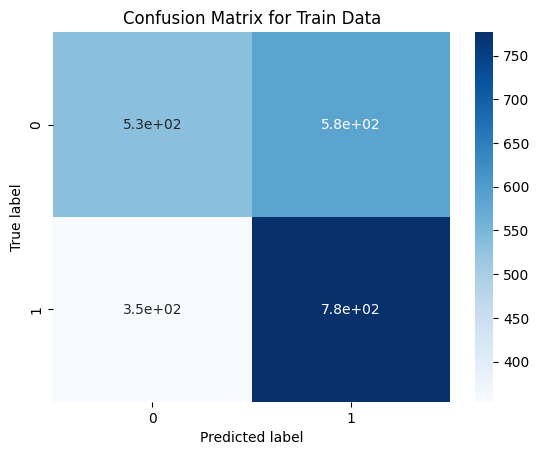

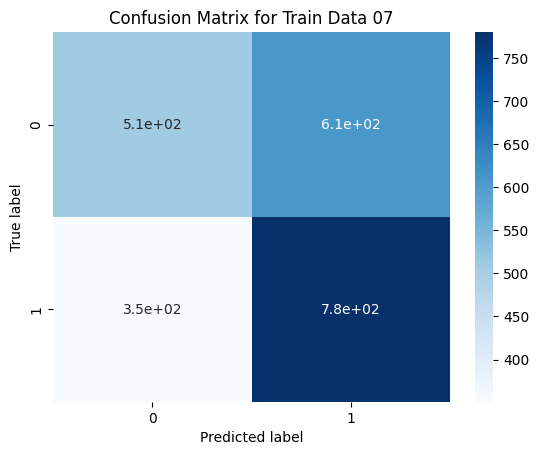

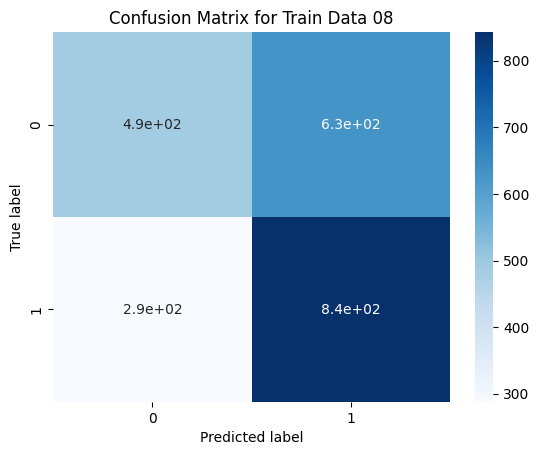

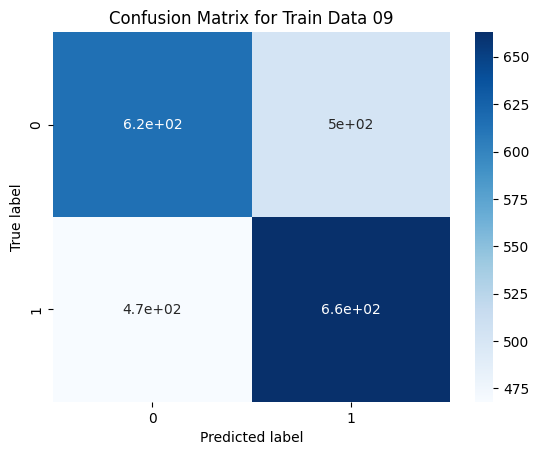

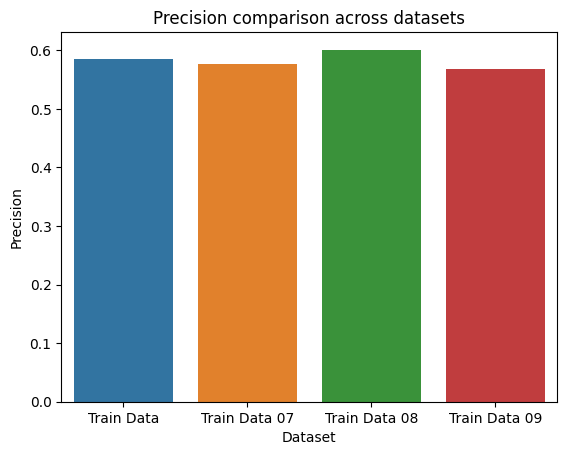

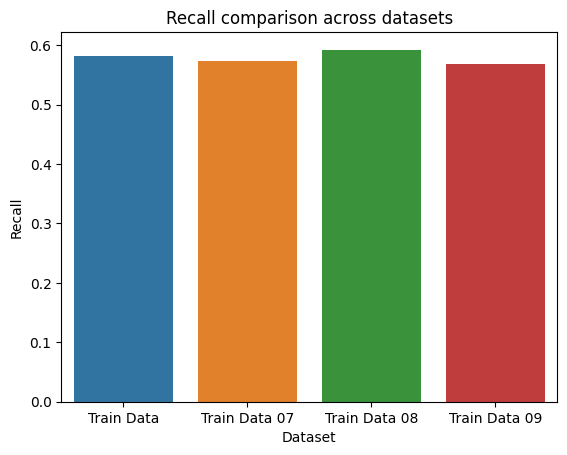

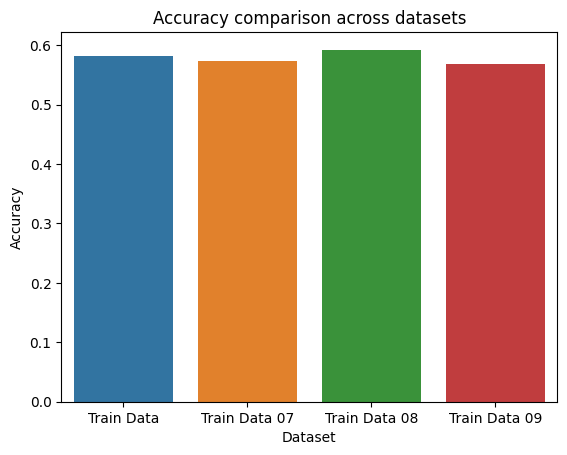

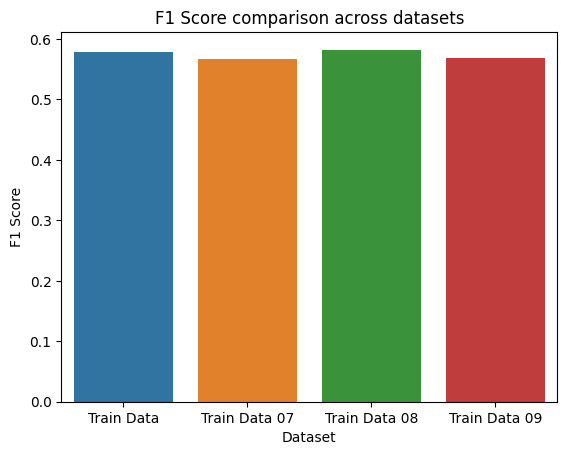

In [17]:

from sklearn.model_selection import GridSearchCV

for dataset in datasets:
    X = dataset.drop(target_column, axis=1)
    y = dataset[target_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid=params, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    y_pred = grid_search.predict(X_test)
    print(best_params)
    # Best params results:
    # {'criterion': 'entropy', 'max_depth': 20, 'max_features': 32, 'min_samples_leaf': 0.1, 'min_samples_split': 0.5, 'splitter': 'best'}
    # {'criterion': 'entropy', 'max_depth': 20, 'max_features': 3, 'min_samples_leaf': 0.1, 'min_samples_split': 0.6, 'splitter': 'best'}
    # {'criterion': 'entropy', 'max_depth': 640, 'max_features': 5, 'min_samples_leaf': 0.1, 'min_samples_split': 0.6, 'splitter': 'best'}
    # {'criterion': 'gini', 'max_depth': 10, 'max_features': 6, 'min_samples_leaf': 0.1, 'min_samples_split': 0.2, 'splitter': 'best'}

    conf_matrix = confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Store the results
    results.append({
        'Confusion Matrix': conf_matrix,
        'Precision': precision,
        'Recall': recall,
        'Accuracy': accuracy,
        'F1 Score': f1,
    })
for i, result in enumerate(results):
    # Create a heatmap of the confusion matrix
    sb.heatmap(result['Confusion Matrix'], annot=True, cmap='Blues')

    # Add labels and title to the plot
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Confusion Matrix for ' + names[i])

    # Show the plot
    plt.show()
metrics = ['Precision', 'Recall', 'Accuracy', 'F1 Score']
for metric in metrics:
    # Extract the metric values for each dataset
    values = [result[metric] for result in results]

    # Create a bar plot to compare the metric values
    sb.barplot(x=names, y=values)

    # Add labels and title to the plot
    plt.xlabel('Dataset')
    plt.ylabel(metric)
    plt.title(f'{metric} comparison across datasets')

    # Show the plot
    plt.show()